This is an extension of the previous notebook to compare ISCE2 `dem.py`, which uses `srtm_v3`. We  note that SRTM is packaged as zip files of gdal compatible files so we have a function to read the tile into memory.

# Initial comparison between `dem-stitcher` and tile (as before)

In [1]:
from dem_stitcher import stitch_dem
from dem_stitcher.stitcher import get_dem_tiles, read_srtm
import rasterio
import matplotlib.pyplot as plt
from rasterio import plot
import geopandas as gpd
from shapely.geometry import box
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import numpy as np
from numpy.testing import assert_array_equal

In [2]:
# Within a Los Angeles tile
la_bounds = [-118.8, 34.6, -118.5, 34.8]

# Select the area that is desired or add your own
bounds = la_bounds

In [3]:
df_request_bounds = gpd.GeoDataFrame(geometry=[box(*bounds)],
                                     crs=CRS.from_epsg(4326))

df = get_dem_tiles(bounds, 'srtm_v3')
df

,geometry,tile_id,url,dem_name
0,"POLYGON ((-119.00000 34.00000, -119.00000 35.0...",N34W119,http://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.00...,srtm_v3


In [4]:
tile_url = df.url.tolist()[0]
X_tile, p_tile = read_srtm(tile_url)

In [5]:
X_tile

array([[465., 463., 459., ..., 783., 781., 782.],
       [464., 463., 460., ..., 780., 780., 781.],
       [457., 456., 454., ..., 779., 779., 780.],
       ...,
       [  0.,   0.,   0., ..., 280., 271., 270.],
       [  0.,   0.,   0., ..., 279., 274., 271.],
       [  0.,   0.,   0., ..., 289., 285., 282.]], dtype=float32)

In [6]:
X_tile = X_tile.astype(np.float32)
X_tile[p_tile['nodata'] == X_tile] = np.nan
p_tile['nodata'] = np.nan
p_tile['driver'] = 'GTiff'
p_tile['dtype'] = np.float32

In [7]:
X_tile

array([[465., 463., 459., ..., 783., 781., 782.],
       [464., 463., 460., ..., 780., 780., 781.],
       [457., 456., 454., ..., 779., 779., 780.],
       ...,
       [  0.,   0.,   0., ..., 280., 271., 270.],
       [  0.,   0.,   0., ..., 279., 274., 271.],
       [  0.,   0.,   0., ..., 289., 285., 282.]], dtype=float32)

We will plot the extent the first tile for illustration.

<AxesSubplot:>

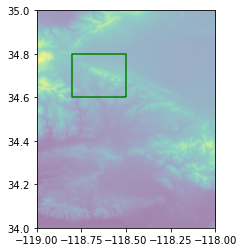

In [8]:
fig, ax = plt.subplots()

plot.show(X_tile, transform=p_tile['transform'], zorder=1, alpha=.5, ax=ax)
df_request_bounds.boundary.plot(ax=ax, color='green', zorder=2)

In [9]:
p_tile

{'driver': 'GTiff', 'dtype': <class 'numpy.float32'>, 'nodata': nan, 'width': 3601, 'height': 3601, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -119.00013888888888,
       0.0, -0.0002777777777777778, 35.00013888888889), 'tiled': False}

In [10]:
X_tile

array([[465., 463., 459., ..., 783., 781., 782.],
       [464., 463., 460., ..., 780., 780., 781.],
       [457., 456., 454., ..., 779., 779., 780.],
       ...,
       [  0.,   0.,   0., ..., 280., 271., 270.],
       [  0.,   0.,   0., ..., 279., 274., 271.],
       [  0.,   0.,   0., ..., 289., 285., 282.]], dtype=float32)

In [11]:
# with rasterio.open('test_srtm.tif', 'w', **p_tile) as ds:
#     ds.write(X_tile, 1)

We are going to get the subset of DEM tiles located in the green box above.

In [12]:
X_subset, p_subset = stitch_dem(bounds, 
                                'srtm_v3', 
                                # The tiles are pixel centered by default
                                dst_area_or_point='Point',
                                # Let's not transform them
                                dst_ellipsoidal_height=False\
                               )

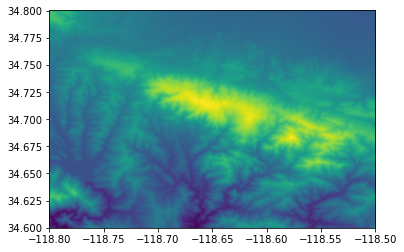

<AxesSubplot:>

In [13]:
plot.show(X_subset, transform=p_subset['transform'])

To compare the original DEM tile and the subset raster we obtained we have to do some resampling. So we are going to reproject back into the tile reference frame.

In [14]:
X_subset_r, _ = reproject_arr_to_match_profile(X_subset, 
                                               p_subset, 
                                               p_tile,
                                               # In QGIS, the pixels will look co-located
                                               resampling='nearest'
                                              )

X_subset_r = X_subset_r[0, ...]

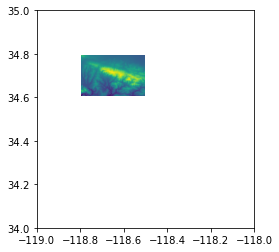

<AxesSubplot:>

In [15]:
plot.show(X_subset_r, transform=p_tile['transform'])

## The comparsions

In [16]:
np.nansum(X_subset_r - X_tile)

0.0

In [17]:
mask = np.isnan(X_subset_r)

data_tile_masked = X_tile[~mask]
data_subset = X_subset_r[~mask]
assert_array_equal(data_tile_masked, data_subset)

# Comparison with ISCE2 dem.py

In [18]:
from pathlib import Path

la_test_dir = Path('la_test')
la_test_dir.mkdir(exist_ok=True)

I ran (per Simran Sangha's guidance)

```
<path_to_python_packagages>/isce/applications/dem.py -a stitch -s 1 -b 34 35 -119 -118 -o la_test.dem
```

Here is the explanation of the CL arguments: https://github.com/isce-framework/isce2/blob/main/applications/dem.py#L60-L90. So with ISCE2 installed it would be something like:

In [19]:
import site

package_loc = site.getsitepackages()
#!{package_loc}/applications/dem.py -a stitch -s 1 -b 34 35 -119 -118 -o la_test/la_test.dem

Once we have 

In [20]:
with rasterio.open('la_test/la_test.dem') as ds:
    X_isce = ds.read(1)
    p_isce = ds.profile

In [21]:
X_isce_r, _ = reproject_arr_to_match_profile(X_isce, 
                                             p_isce, 
                                             p_tile,
                                             resampling='nearest'
                                             )

X_isce_r = X_isce_r[0, ...]

So they are definitely not preserving the tiles as well because of some resampling that is being done.

In [22]:
np.nansum(X_isce_r - X_tile)

-3197691.0

ISCE2 is ensuring a fixed resolution as frequently done with `gdal`, which is a different approach and does not preserve the tiles in the same manner.

In [23]:
p_isce['transform']

Affine(0.0002777777777777778, 0.0, -119.0,
       0.0, -0.0002777777777777778, 35.0)